<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 33.9 MB/s 


###Load Libraries

In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from time import time

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [3]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [4]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [5]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [6]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [7]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

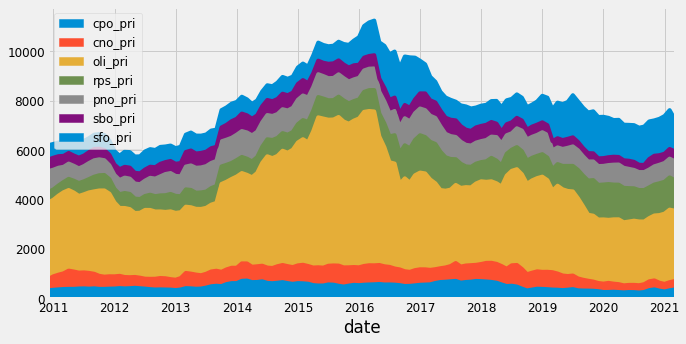

In [8]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [9]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [10]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [11]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [12]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [13]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [14]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [15]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [16]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [ ]:
#test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["date"]).unstack().shift(3).stack()

In [38]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(50, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(32, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1))

# compile model using adam
cnn_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=20)

# model evaluation
cnn_model.evaluate(X_test, y_test)


#cnn_model.compile(loss='mse', optimizer='adam')
#cnn_model.summary()

Epoch 1/20
3/3 [==============================] - 1s 103ms/step - loss: 0.3036 - mse: 0.3036 - val_loss: 0.3790 - val_mse: 0.3790
Epoch 2/20
3/3 [==============================] - 0s 14ms/step - loss: 0.1231 - mse: 0.1231 - val_loss: 0.1880 - val_mse: 0.1880
Epoch 3/20
3/3 [==============================] - 0s 16ms/step - loss: 0.0432 - mse: 0.0432 - val_loss: 0.1132 - val_mse: 0.1132
Epoch 4/20
3/3 [==============================] - 0s 16ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.0898 - val_mse: 0.0898
Epoch 5/20
3/3 [==============================] - 0s 16ms/step - loss: 0.0273 - mse: 0.0273 - val_loss: 0.0832 - val_mse: 0.0832
Epoch 6/20
3/3 [==============================] - 0s 19ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 7/20
3/3 [==============================] - 0s 14ms/step - loss: 0.0226 - mse: 0.0226 - val_loss: 0.0738 - val_mse: 0.0738
Epoch 8/20
3/3 [==============================] - 0s 17ms/step - loss: 0.0159 - mse: 0.0159 - va

[0.07869140058755875, 0.07869140058755875]

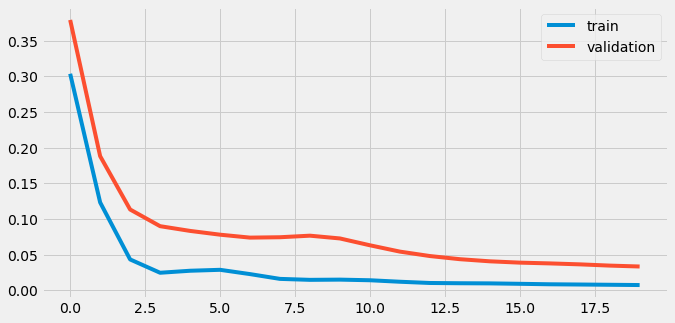

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [40]:
mse_cnn = cnn_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 0.0787 - mse: 0.0787


####Baseline MSE = 0.0787

In [41]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2, 64)             960       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 50)                3250      
                                                                 
 dense_10 (Dense)            (None, 32)                1632      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                      

###Predict the Test without Hyperparameter Tuning

In [42]:
y_pred = cnn_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 84ms/step


array([[0.22879545],
       [0.2139227 ],
       [0.22308613],
       [0.23436084],
       [0.2341931 ],
       [0.19661205],
       [0.18623857],
       [0.19979344],
       [0.1930549 ],
       [0.19155023],
       [0.19672878],
       [0.20129736],
       [0.20176573],
       [0.20030439],
       [0.19055998],
       [0.18165497],
       [0.17120627],
       [0.18666042],
       [0.21851245],
       [0.19408299],
       [0.19448486],
       [0.19559069]], dtype=float32)

In [43]:
y_pred.reshape(1,-1)

array([[0.22879545, 0.2139227 , 0.22308613, 0.23436084, 0.2341931 ,
        0.19661205, 0.18623857, 0.19979344, 0.1930549 , 0.19155023,
        0.19672878, 0.20129736, 0.20176573, 0.20030439, 0.19055998,
        0.18165497, 0.17120627, 0.18666042, 0.21851245, 0.19408299,
        0.19448486, 0.19559069]], dtype=float32)

###Invert Transformed Data

In [44]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[410.51816 404.5691  408.23447 412.74432 412.67725 397.64484 393.49545
  398.9174  396.222   395.6201  397.6915  399.51895 399.7063  399.12177
  395.224   391.662   387.4825  393.66418 406.40497 396.6332  396.79395
  397.23627]]


###Plot History, Actual and Predicted Value

In [45]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [46]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [47]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([410.51816, 404.5691 , 408.23447, 412.74432, 412.67725, 397.64484,
       393.49545, 398.9174 , 396.222  , 395.6201 , 397.6915 , 399.51895,
       399.7063 , 399.12177, 395.224  , 391.662  , 387.4825 , 393.66418,
       406.40497, 396.6332 , 396.79395, 397.23627], dtype=float32)

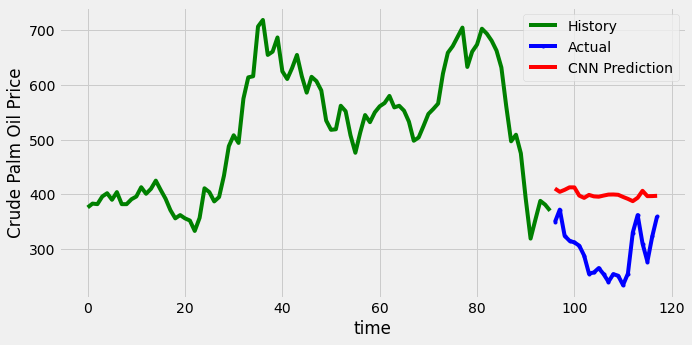

In [48]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('time')
plt.legend()
plt.show();

###Evaluate CNN Model Accuracy

In [49]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

#EVS_cnn = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the CNN Model is:', EVS_cnn)

MAE value of the CNN Model is: 104.4901192405007
MDA value of the CNN Model is: 0.47619047619047616
MAPE value of the CNN Model is: 38.077694415426734
RMSE value of the CNN Model is: 112.20795538289873
MSE value of the CNN Model is: 12590.625251210591


####Actual VS Predicted CNN Model

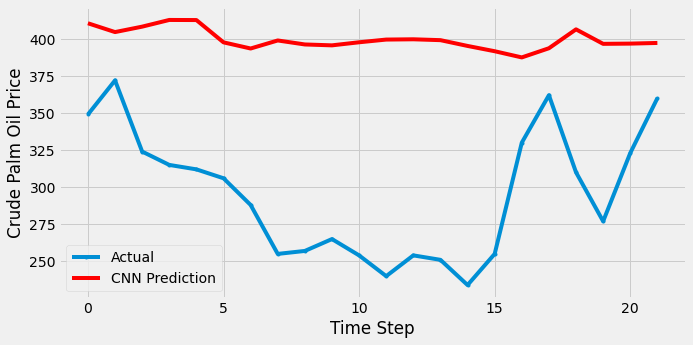

In [50]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

###Tuning CNN with Keras Tuner

In [51]:
class ANNhypermodel(HyperModel):
#class CNNHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
        
        
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)

        model.add(keras.layers.Dense(units=hp_units_1, activation='relu', input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='relu'))
        model.add(keras.layers.Dense(1))

        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)

        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
#hypermodel = CNNHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [52]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [53]:
tuner_rs.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [54]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 410ms/step - loss: 0.3510 - mae: 0.5822 - mse: 0.3510


####Random Search MSE = 0.3510

In [55]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 160,
 'units_2': 96,
 'units_3': 64,
 'dropout': 0.05,
 'learning_rate': 0.008547485565344062}

###Build Bayesian Optimization

In [56]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [57]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 388ms/step - loss: 0.3848 - mae: 0.6106 - mse: 0.3848


###Evaluate Bayesian Optimization

In [58]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units_1': 160,
 'units_2': 128,
 'units_3': 64,
 'dropout': 0.0,
 'learning_rate': 0.01}

###Build HYPERBAND optimization

In [398]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [399]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [400]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!
1095.3481576442719  secs


In [401]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')} 
drop out is {best_hps.get('dropout')}
#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 128,
second layer is 96 
third layer is 32 
drop out is 0.2
#learning rate is 0.00034863892704459074                                        

and the optimal learning rate for the optimizer
is 0.00034863892704459074.

[]
1/1 [==============================] - 0s 441ms/step - loss: 0.0114 - mae: 0.0947 - mse: 0.0114
loss:0.01140366867184639 mae: 0.09468782693147659 mse: 0.01140366867184639


####Hyperband MSE = 0.0114

###Apply tuned parameter

In [179]:
TUcnn_model = tf.keras.Sequential()
TUcnn_model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
TUcnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
TUcnn_model.add(tf.keras.layers.Flatten())
TUcnn_model.add(tf.keras.layers.Dense(96, activation='tanh'))
TUcnn_model.add(tf.keras.layers.Dense(32, activation='tanh'))
TUcnn_model.add(layers.Dropout(0.2))

TUcnn_model.add(tf.keras.layers.Dense(1, 'linear'))
# compile model using adam
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
TUcnn_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.Adam(learning_rate=0.01140366867184639), metrics= ['mae', 'mse'])
TUcnn_model.compile(optimizer='adam',loss='mse',metrics=['mse']),

history = TUcnn_model.fit(X_train, y_train, validation_split=0.2, epochs=12)

# model evaluation
TUcnn_model.evaluate(X_test, y_test)

Epoch 1/12
3/3 [==============================] - 1s 87ms/step - loss: 0.1504 - mse: 0.1504 - val_loss: 0.0829 - val_mse: 0.0829
Epoch 2/12
3/3 [==============================] - 0s 14ms/step - loss: 0.1090 - mse: 0.1090 - val_loss: 0.0277 - val_mse: 0.0277
Epoch 3/12
3/3 [==============================] - 0s 14ms/step - loss: 0.0521 - mse: 0.0521 - val_loss: 0.0957 - val_mse: 0.0957
Epoch 4/12
3/3 [==============================] - 0s 16ms/step - loss: 0.0400 - mse: 0.0400 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 5/12
3/3 [==============================] - 0s 14ms/step - loss: 0.0319 - mse: 0.0319 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 6/12
3/3 [==============================] - 0s 25ms/step - loss: 0.0336 - mse: 0.0336 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 7/12
3/3 [==============================] - 0s 17ms/step - loss: 0.0201 - mse: 0.0201 - val_loss: 0.0270 - val_mse: 0.0270
Epoch 8/12
3/3 [==============================] - 0s 33ms/step - loss: 0.0272 - mse: 0.0272 - val

[0.00958162546157837, 0.00958162546157837]

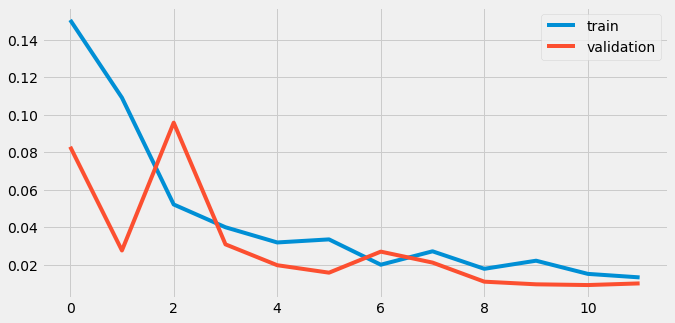

In [180]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [181]:
y_pred2 = TUcnn_model.predict(X_test)
y_pred2

1/1 [==============================] - 0s 75ms/step


array([[ 0.00222005],
       [ 0.01772738],
       [ 0.03807942],
       [ 0.03184017],
       [-0.01358929],
       [-0.02694928],
       [-0.04086257],
       [-0.04215087],
       [-0.08277935],
       [-0.10515022],
       [-0.09437406],
       [-0.1166507 ],
       [-0.14317378],
       [-0.13804807],
       [-0.1287297 ],
       [-0.14893645],
       [-0.17378077],
       [-0.12300178],
       [ 0.04025671],
       [ 0.10477741],
       [ 0.00429612],
       [ 0.0176297 ]], dtype=float32)

In [182]:
y_pred2.reshape(1,-1)

array([[ 0.00222005,  0.01772738,  0.03807942,  0.03184017, -0.01358929,
        -0.02694928, -0.04086257, -0.04215087, -0.08277935, -0.10515022,
        -0.09437406, -0.1166507 , -0.14317378, -0.13804807, -0.1287297 ,
        -0.14893645, -0.17378077, -0.12300178,  0.04025671,  0.10477741,
         0.00429612,  0.0176297 ]], dtype=float32)

In [183]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred2.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[319.88803 326.09094 334.23175 331.73605 313.56427 308.22028 302.65497
  302.13965 285.88828 276.9399  281.25037 272.33972 261.73047 263.7808
  267.50812 259.4254  249.48769 269.7993  335.1027  360.91095 320.71844
  326.05188]]


In [184]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [185]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [186]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([319.88803, 326.09094, 334.23175, 331.73605, 313.56427, 308.22028,
       302.65497, 302.13965, 285.88828, 276.9399 , 281.25037, 272.33972,
       261.73047, 263.7808 , 267.50812, 259.4254 , 249.48769, 269.7993 ,
       335.1027 , 360.91095, 320.71844, 326.05188], dtype=float32)

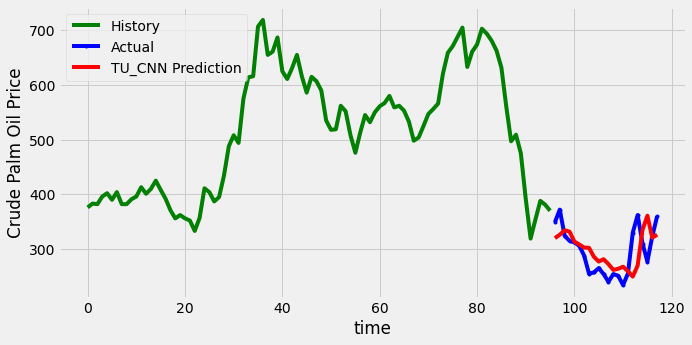

In [187]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="TU_CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('time')
plt.legend()
plt.show();

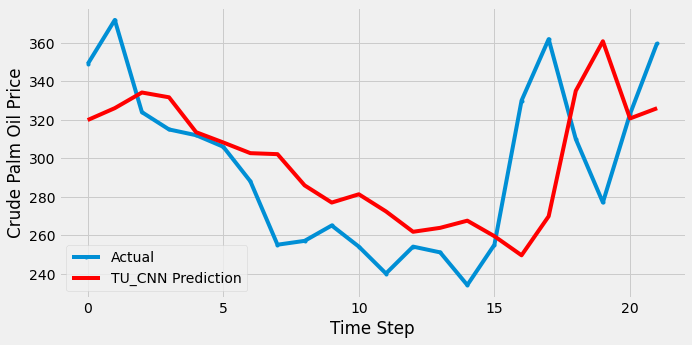

In [188]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="TU_CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [189]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

MAE value of the CNN Model is: 29.29033660888672
MDA value of the CNN Model is: 0.42857142857142855
MAPE value of the CNN Model is: 9.840442899316631
RMSE value of the CNN Model is: 39.15431125100251
MSE value of the CNN Model is: 1533.060089540382


In [ ]:
# 14  = 39.717, next16, next 20 17 /mse 48 18/mse 55 19/rmse 90->48 RMSE,  
